In [1]:
import numpy as np 
import matplotlib.pyplot as plt

# Epydemix import
import sys
sys.path.append("../")
from epydemix.population import Population
from epydemix.epimodel import EpiModel
from epydemix.plotting import plot_quantiles

# EpiModel Object

The ```EpiModel``` object is the core of the ```epydemix``` simulation module. With ```EpiModel``` objects we can define flexible epidemic model and then simulate them. Before creating the first ```EpiModel``` we need to create a ```Population``` object, which is needed for the simulation

In [2]:
population = Population() 
population.load_population(population_name="Indonesia", path_to_data="../epydemix_data/")

We can now define the ```EpiModel``` object. This requires three simple steps: 
- Definition of compartments
- Definition of model parameters
- Definition of transitions


Parameters can also be defined before compartments, while transitions must be defined after the definition of compartments, otherwise this will raise an error. Let's see how this works in practive by creating a simple SIR model:

In [3]:
# create model 
model = EpiModel(compartments=["S", "R"])

# compartments can be also added after the first init call
model.add_compartments("I")

# define parameters
model.add_parameters({"bet": 0.04, "mu": 0.2})

# add transitions 
model.add_transition(source="S", target="I", rate_name="bet", agent="I")
model.add_transition(source="I", target="R", rate_name="mu")

In more details: 
- compartments are string identifying the name of the compartment. They can be added when creating the ```EpiModel``` object of afterwards using the ```add_compartments``` method (which takes as input both single and list of compartments)

- parameters are represented as a dictionary whose keys (values) are the names (values) of the parameters. They can be added when creating the ```EpiModel``` object of afterwards using the ```add_parameters``` method, which takes as input a dictionary. The dictionary can contain single or multiple parameters. 

- transitions are represented as ```Transition``` objects and they have the following attributes: 
    - source: the name of the source compartment of the transition
    - target: the name of the target compartment of the transition
    - rate_name: the expression of the rate of the transition
    - agent: the name of the compartment which catalyzes the transition (in case of spontaneous transitions it is set to None)

<div class="alert alert-block alert-warning"><b>Important Note: </b> some parameter names, such as 'beta' and 'gamma' cannot be used. This is because rate_name are evaluated as composite expressions using sympy and some names may be in conflict with this python package. This is done to allow for transitions that have composite expressions for the rate (more details below). </div>

TODO: MORE DETAILS ON THE SIMULATION (STOCHASTIC, CHAIN BINOMIALS)

We are now ready to run our first simulation. To do so, we will need to specify the population object, start and end date of the simulation, the initial conditions for each compartment, the number of steps for each simulation, and thet total number of stochastic simulations (default is 100): 


In [4]:
results = model.simulate(population=population, 
                         start_date="2019-12-01", 
                         end_date="2020-04-01", 
                         S=population.Nk - np.ones(len(population.Nk)),
                         I=np.ones(len(population.Nk)),
                         R=np.zeros(len(population.Nk)),
                         steps="daily", 
                         Nsim=100)

We can plot the output:

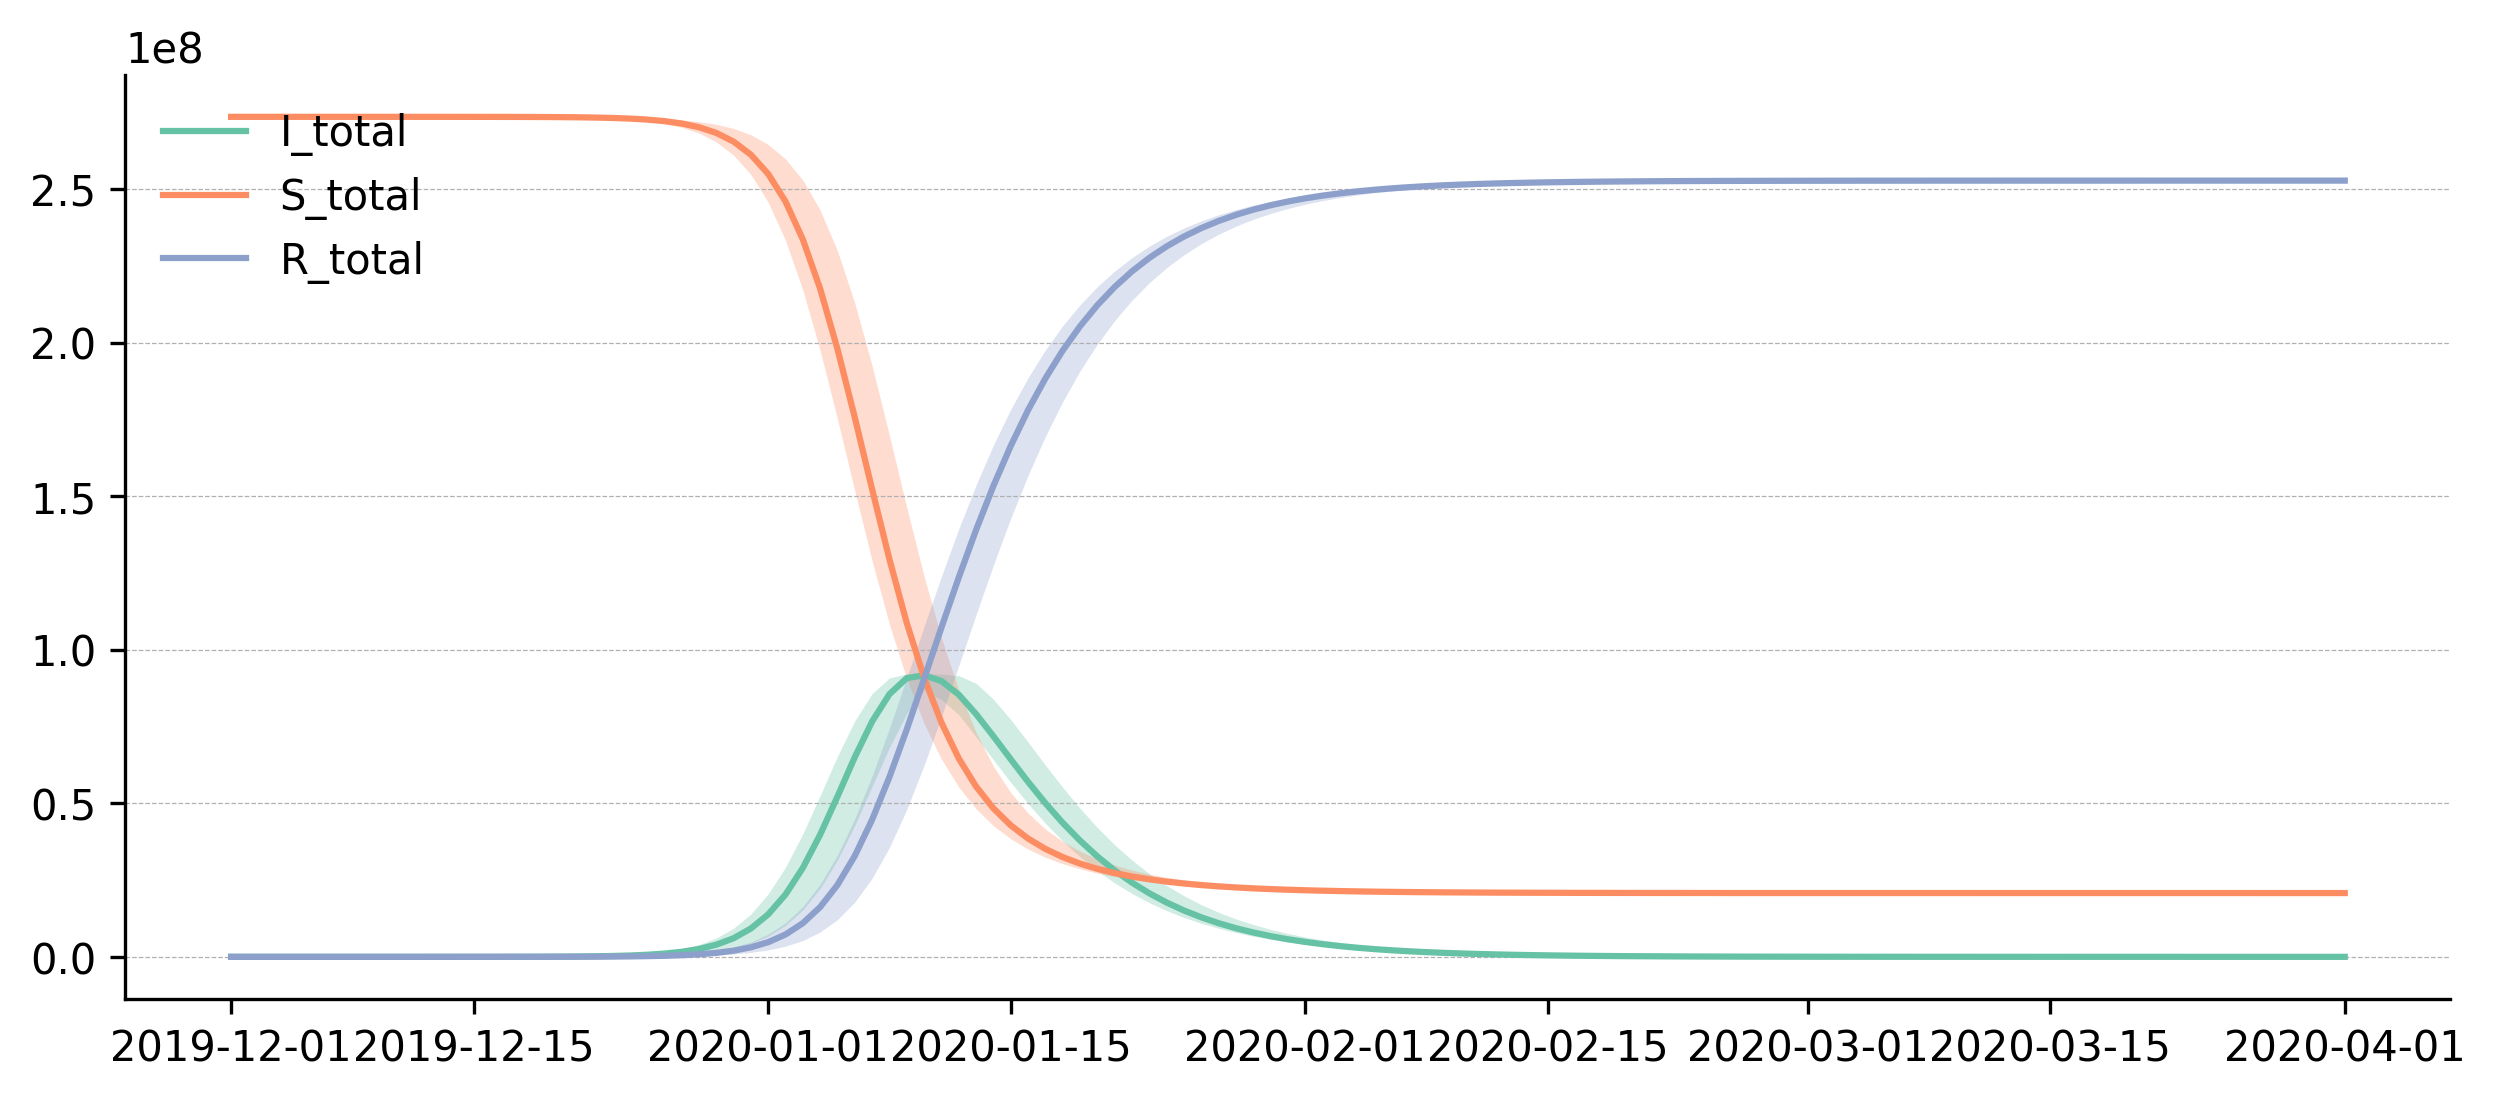

In [5]:
plot_quantiles(results, columns=["I_total", "S_total", "R_total"])

# Modeling Interventions

With ```EpiModel```, we can also model the impact of interventions aimed at reducing or changing the pattern of contacts. To do so, we need to define the set of interventions before calling the ```simulate``` function.

Interventions can be defined using the ```add_intervention``` method, which takes the following parameters:

- ```layer_name```: The name of the contacts layer to which the intervention is applied (e.g., 'work', 'school').
- ```start_date```: The start date of the intervention.
- ```end_date```: The end date of the intervention.
- ```reduction_factor```: A float determining the reduction factor of contacts in the specified contact layer. For example, ```reduction_factor=0.3``` implies a 70% reduction in contacts.
- ```new_matrix```: Instead of applying a reduction factor to all contacts in the contact layer, you can pass a new contact matrix to be used during the intervention period.

In the following example, we add two interventions, one to the work contact layer, from 2020-01-01 to 2020-05-01 implying an overall 70% reduction in contacts, and one to the school contact layer from 2019-01-01 to 2020-06-01 implying a 55% reduction in contacts in this layer.

In [6]:
# add interventions by using a multplying factor
model.add_intervention(layer_name="work", start_date="2020-01-01", end_date="2020-05-01", reduction_factor=0.3)
model.add_intervention(layer_name="school", start_date="2019-01-01", end_date="2020-06-01", reduction_factor=0.45)

We also add a third intervention where instead of using a multplying factor, we consider a new matrix from 2020-01-01 to 2020-03-01 for the community layer.

In [7]:
# add interventions by changing the contact matrix
comm_matrix = population.contact_matrices["community"].copy()
comm_matrix[6:] = 0
model.add_intervention(layer_name="community", start_date="2020-01-01", end_date="2020-03-01", new_matrix=comm_matrix)

Finally we simulate the model with interventions added and we plot results:

In [8]:
results_interventions = model.simulate(population=population, 
                         start_date="2019-12-01", 
                         end_date="2020-04-01", 
                         S=population.Nk - np.ones(len(population.Nk)),
                         I=np.ones(len(population.Nk)),
                         R=np.zeros(len(population.Nk)),
                         steps="daily", 
                         Nsim=100)

We plot the results of the simulation with and without intervention:

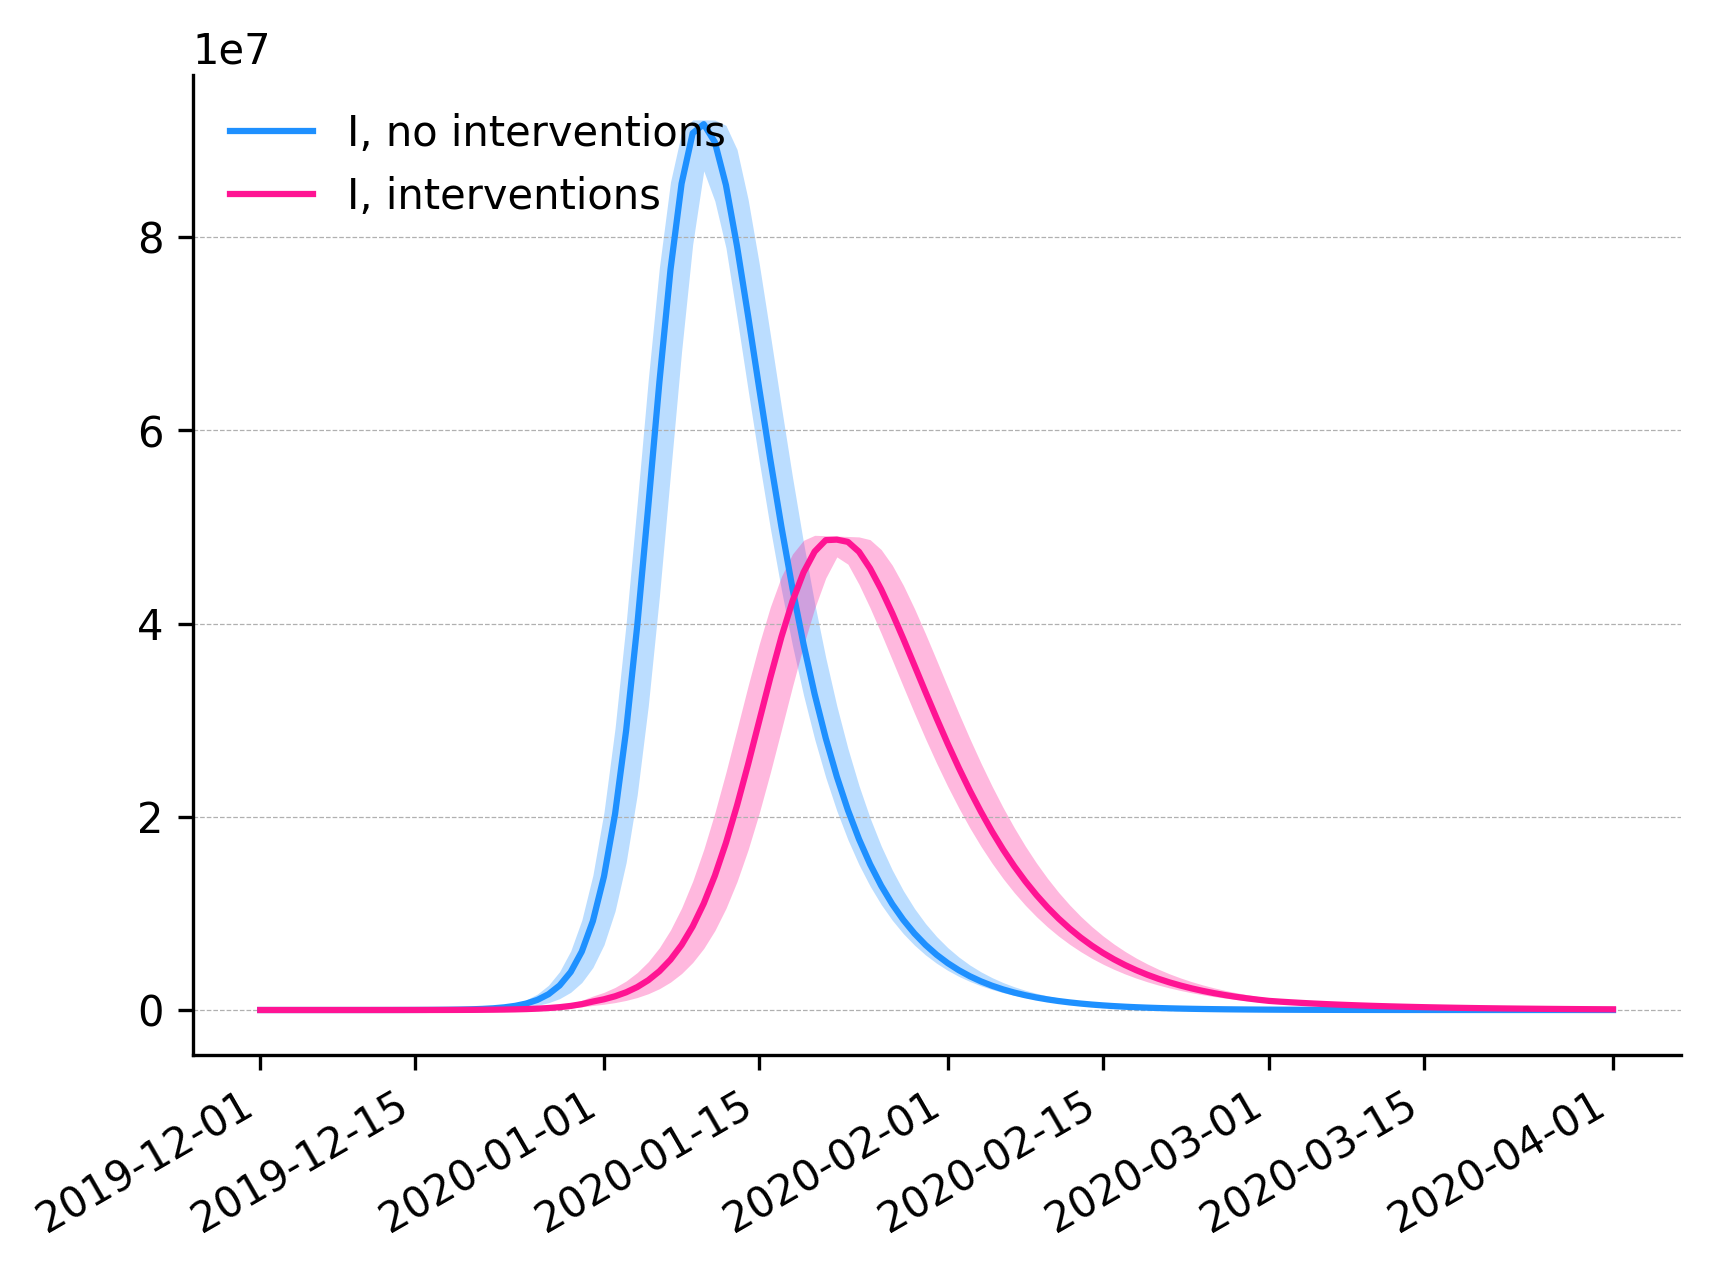

In [18]:
fig, ax = plt.subplots(dpi=300)
plot_quantiles(results, columns="I_total", ax=ax, colors="dodgerblue", labels="I, no interventions")
plot_quantiles(results_interventions, columns="I_total", ax=ax, colors="deeppink", labels="I, interventions")
fig.autofmt_xdate()

We can also plot the number of infected over time in specific age groups, for example 0 to 4 and 5 to 9:

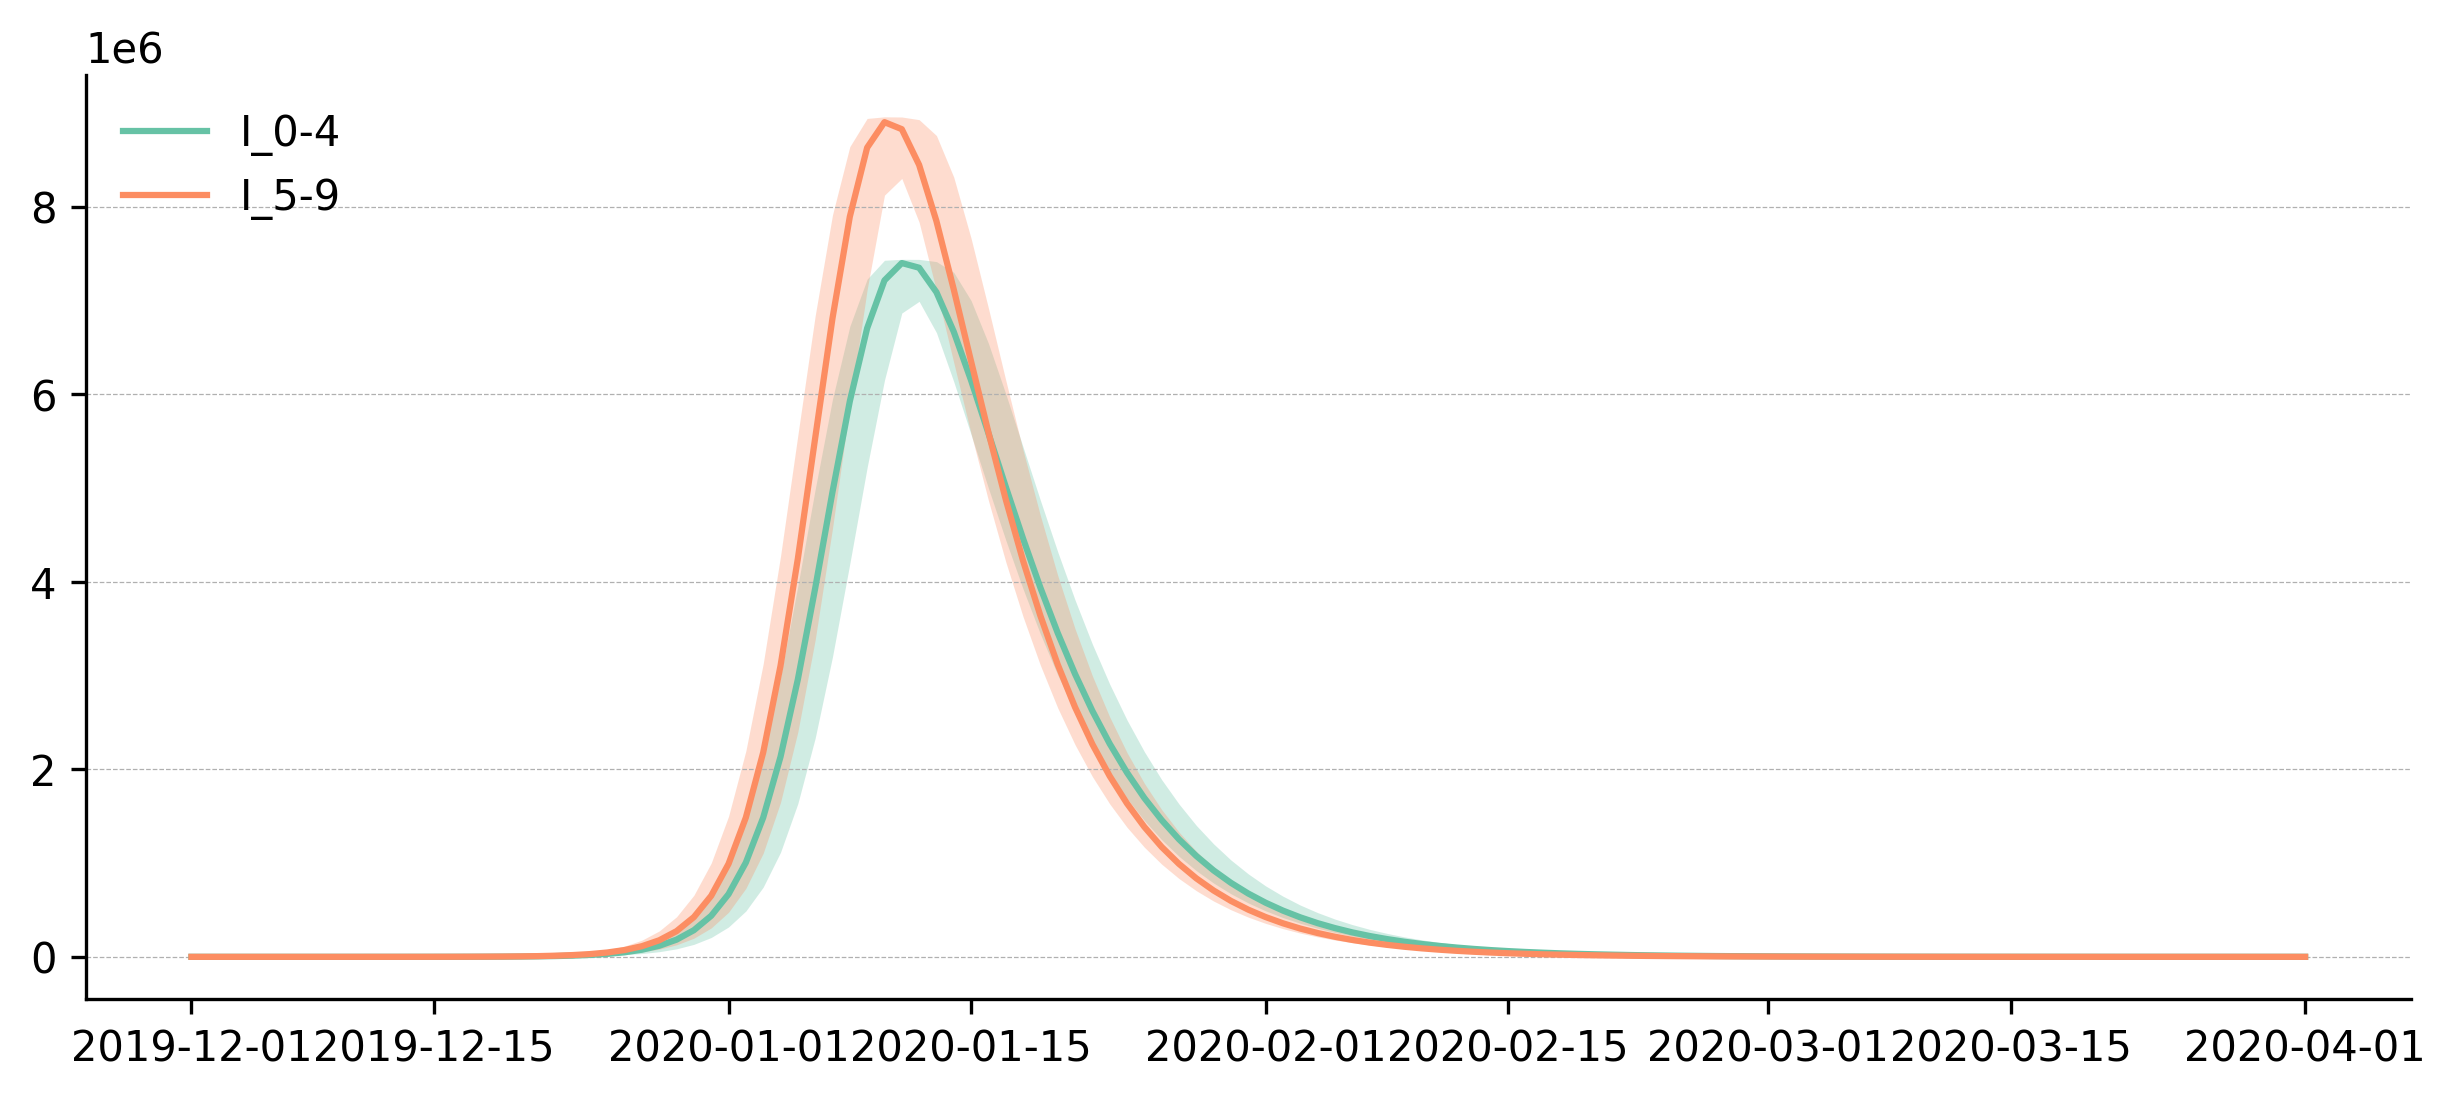

In [12]:
plot_quantiles(results, columns=["I_0-4", "I_5-9"])

# More Complex Compartmentalization Structures

The EpiModel object allows to create complex comparmental models. For example, we consider here a SEIR-like model with two different virus strains:


<div>
<img src="./img/two_strains_SEIR.svg" width="500"/>
</div>

Strain 2 has the same latent and infectious period, but a different transmission rate. In particular: 

$$\beta_2 = \beta_1 * \psi$$

Where $\psi$ indicates the increased transmissibility of Strain 2. In EpiModel, you can use symbolic expressions for rates, which is particularly useful for composite expressions like this.

In [ ]:
# create model 
model = EpiModel(compartments=["S", "E1", "E2", "I1", "I2", "R1", "R2"])

# define parameters
model.add_parameters({"bet": 0.04, "mu": 0.2, "psi": 1.2, "eps": 0.25})

# add transitions 
model.add_transition(source="S", target="E1", rate_name="bet", agent="I1")
model.add_transition(source="S", target="E2", rate_name="bet*psi", agent="I2")
model.add_transition(source="E1", target="I1", rate_name="eps")
model.add_transition(source="E2", target="I2", rate_name="eps")
model.add_transition(source="I1", target="R1", rate_name="mu")
model.add_transition(source="I2", target="R2", rate_name="mu")


In [ ]:
results = model.simulate(population=population, 
                         start_date="2019-12-01", 
                         end_date="2020-05-01", 
                         S=population.Nk - 2 * np.ones(len(population.Nk)),
                         I1=np.ones(len(population.Nk)),
                         E1=np.ones(len(population.Nk)),
                         R1=np.zeros(len(population.Nk)),
                         I2=np.ones(len(population.Nk)),
                         E2=np.ones(len(population.Nk)),
                         R2=np.zeros(len(population.Nk)),
                         steps="daily", 
                         Nsim=100)

In [ ]:
plot_quantiles(results, columns=["I1_total", "I2_total"])